In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:
!pip install split-folders


In [6]:
import os
import shutil
import splitfolders
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

In [ ]:
import os
import shutil
import random
dataset_dir = "lung_colon_image_set"
output_dir = "dataset_split"
train_ratio = 0.8

# Create train/test folders
for split in ["train", "test"]:
    for category in ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]:
        os.makedirs(os.path.join(output_dir, split, category), exist_ok=True)

for category in ["colon_aca", "colon_n", "lung_aca", "lung_n", "lung_scc"]:
    # Get category path
    if "colon" in category:
        category_path = os.path.join(dataset_dir, "colon_image_sets", category)
    else:
        category_path = os.path.join(dataset_dir, "lung_image_sets", category)
    
    images = os.listdir(category_path)
    random.shuffle(images)
    
    split_index = int(len(images) * train_ratio)
    train_files = images[:split_index]
    test_files = images[split_index:]
    
    # Copy images
    for img in train_files:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_dir, "train", category))
    for img in test_files:
        shutil.copy(os.path.join(category_path, img), os.path.join(output_dir, "test", category))

print("Train/Test split completed successfully.")

Train/Test split completed successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=20,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.1  # 10% for validation
)
train_generator = train_datagen.flow_from_directory(
    "dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="training"  # use 90% of train
)
val_generator = train_datagen.flow_from_directory(
    "dataset_split/train",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    subset="validation"  # use 10% of train
)
test_generator = test_datagen.flow_from_directory(
    "dataset_split/test",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False  # important for consistent predictions
)

Found 18000 images belonging to 5 classes.
Found 2000 images belonging to 5 classes.
Found 5000 images belonging to 5 classes.


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, LeakyReLU, BatchNormalization

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam

IMG_SIZE = (224, 224)

# Get number of classes automatically
num_classes = train_generator.num_classes
class_indices = train_generator.class_indices
print("Detected classes:", class_indices)

# Load pretrained ResNet50 without top classifier
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3)
)
# Freeze base model layers
base_model.trainable = False

# Build your model
mon_model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(256, activation="relu"),
    Dropout(0.4),
    Dense(128, activation="relu"),
    Dropout(0.3),
    Dense(num_classes, activation="softmax")   # ✅ correct number of classes
])
# Compile
mon_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",  # ✅ because generators give one-hot labels
    metrics=["accuracy"]
)
# Summary
mon_model.summary()

Detected classes: {'colon_aca': 0, 'colon_n': 1, 'lung_aca': 2, 'lung_n': 3, 'lung_scc': 4}


I0000 00:00:1756167827.200104      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1756167827.200953      36 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 24,145,797 (92.11 MB)

 Trainable params: 558,085 (2.13 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [ ]:
history = mon_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=10
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10


I0000 00:00:1756167842.663408     126 service.cc:148] XLA service 0x7906e4012850 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1756167842.665124     126 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1756167842.665155     126 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1756167844.322064     126 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/563 ━━━━━━━━━━━━━━━━━━━━ 2:54:30 19s/step - accuracy: 0.2188 - loss: 2.1238

I0000 00:00:1756167850.194306     126 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


563/563 ━━━━━━━━━━━━━━━━━━━━ 272s 450ms/step - accuracy: 0.2350 - loss: 1.6659 - val_accuracy: 0.4650 - val_loss: 1.4425
Epoch 2/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 241s 427ms/step - accuracy: 0.4132 - loss: 1.4225 - val_accuracy: 0.5490 - val_loss: 1.2045
Epoch 3/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 246s 436ms/step - accuracy: 0.4865 - loss: 1.2358 - val_accuracy: 0.5560 - val_loss: 1.0808
Epoch 4/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 239s 424ms/step - accuracy: 0.5220 - loss: 1.1337 - val_accuracy: 0.5790 - val_loss: 1.0165
Epoch 5/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 236s 420ms/step - accuracy: 0.5505 - loss: 1.0608 - val_accuracy: 0.6060 - val_loss: 0.9650
Epoch 6/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 247s 439ms/step - accuracy: 0.5772 - loss: 1.0132 - val_accuracy: 0.6515 - val_loss: 0.9308
Epoch 7/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 254s 451ms/step - accuracy: 0.6051 - loss: 0.9621 - val_accuracy: 0.6460 - val_loss: 0.8609
Epoch 8/10
563/563 ━━━━━━━━━━━━━━━━━━━━ 243s 431ms/step - accuracy: 0.6282 - loss: 0.90

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,   # stop if no improvement after 5 epochs
    restore_best_weights=True
)

checkpoint = ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6
)


In [14]:
# Unfreeze last 50 layers for fine-tuning
for layer in base_model.layers[-50:]:
    layer.trainable = True

mon_model.compile(
    optimizer=Adam(learning_rate=1e-5),   # smaller LR for fine-tuning
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)


history = mon_model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=20,
    callbacks=[early_stop, checkpoint, reduce_lr],
)


Epoch 1/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 297s 473ms/step - accuracy: 0.7730 - loss: 0.5554 - val_accuracy: 0.5375 - val_loss: 1.4211 - learning_rate: 1.0000e-05
Epoch 2/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 253s 449ms/step - accuracy: 0.8064 - loss: 0.4905 - val_accuracy: 0.8550 - val_loss: 0.3854 - learning_rate: 1.0000e-05
Epoch 3/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 250s 443ms/step - accuracy: 0.8290 - loss: 0.4384 - val_accuracy: 0.7715 - val_loss: 0.5326 - learning_rate: 1.0000e-05
Epoch 4/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 252s 448ms/step - accuracy: 0.8288 - loss: 0.4363 - val_accuracy: 0.7110 - val_loss: 0.8672 - learning_rate: 1.0000e-05
Epoch 5/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 252s 447ms/step - accuracy: 0.8369 - loss: 0.4108 - val_accuracy: 0.7825 - val_loss: 0.5387 - learning_rate: 1.0000e-05
Epoch 6/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 252s 448ms/step - accuracy: 0.8639 - loss: 0.3413 - val_accuracy: 0.9015 - val_loss: 0.2414 - learning_rate: 2.0000e-06
Epoch 7/20
563/563 ━━━━━━━━━━━━━━━━━━━━ 

In [15]:
# ✅ Evaluate on test set
test_loss, test_acc = mon_model.evaluate(test_generator)
print(f"Test Accuracy: {test_acc:.4f}, Test Loss: {test_loss:.4f}")

157/157 ━━━━━━━━━━━━━━━━━━━━ 22s 137ms/step - accuracy: 0.9258 - loss: 0.2057
Test Accuracy: 0.9120, Test Loss: 0.2551


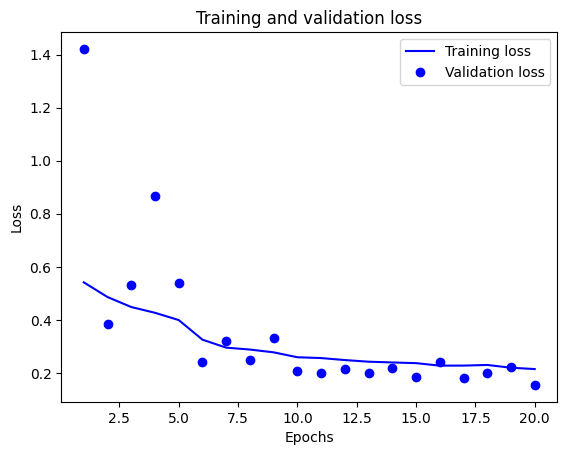

In [16]:
import matplotlib.pyplot as plt

history_dict = history.history

# Loss values
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]

# Accuracy values
acc_values = history_dict["accuracy"]
val_acc_values = history_dict["val_accuracy"]

epochs = range(1, len(loss_values) + 1)

# Plot training & validation loss
plt.plot(epochs, loss_values, "b", label="Training loss")
plt.plot(epochs, val_loss_values, "bo", label="Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

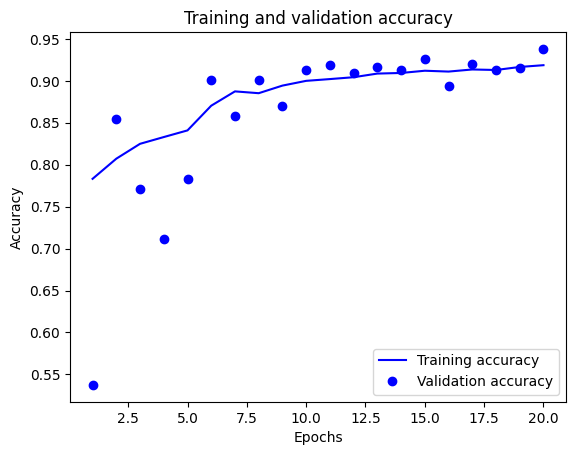

In [17]:
# Plot training & validation accuracy
plt.plot(epochs, acc_values, "b", label="Training accuracy")
plt.plot(epochs, val_acc_values, "bo", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_directory(
    "dataset_split/test",        # path to your test folder
    target_size=(224, 224),      # same size used during training
    batch_size=32,
    class_mode="categorical",
    shuffle=False                # VERY IMPORTANT
)
import numpy as np

pred_probs = mon_model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes

Found 5000 images belonging to 5 classes.


In [20]:
import numpy as np

pred_probs = mon_model.predict(test_generator)
y_pred = np.argmax(pred_probs, axis=1)
y_true = test_generator.classes


157/157 ━━━━━━━━━━━━━━━━━━━━ 28s 145ms/step


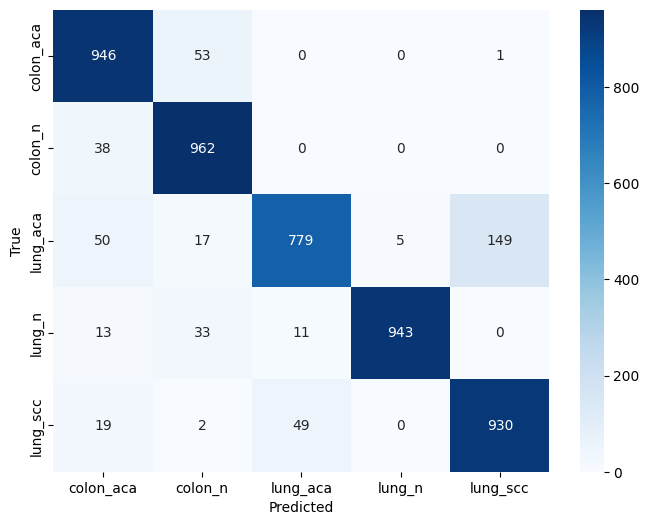

              precision    recall  f1-score   support

   colon_aca       0.89      0.95      0.92      1000
     colon_n       0.90      0.96      0.93      1000
    lung_aca       0.93      0.78      0.85      1000
      lung_n       0.99      0.94      0.97      1000
    lung_scc       0.86      0.93      0.89      1000

    accuracy                           0.91      5000
   macro avg       0.91      0.91      0.91      5000
weighted avg       0.91      0.91      0.91      5000



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import matplotlib.pyplot as plt
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm,
            annot=True, fmt="d", cmap="Blues",
            xticklabels=test_generator.class_indices.keys(),
            yticklabels=test_generator.class_indices.keys())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

print(classification_report(y_true, y_pred,
target_names=test_generator.class_indices.keys()))

In [ ]:
# Save model
mon_model.save("/kaggle/working/my_model.h5")
import shutil
shutil.make_archive("/kaggle/working/my_model_backup", 'zip', "/kaggle/working")
